In [23]:
import tensorflow as tf
from tensorflow import keras
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import cv2




In [24]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table

	return cv2.LUT(image, table)

* [How connect spectrum](www.fourmilab.ch/documents/specrend/)
* [Python library](https://python-colormath.readthedocs.io/en/latest/color_objects.html#spectralcolor)


In [25]:
from colormath import spectral_constants
# Spectrum to CIE
# from 340 nm to 830 by 10 nm steps
class SpectrumColor:
    MIN_NM = 340
    MAX_NM = 830
    REF_ILLUM = spectral_constants.REF_ILLUM_TABLE['d50']
    DENOM =  np.sum(REF_ILLUM
                   * spectral_constants.STDOBSERV_Y10)
    SPECTRUM2XYZ = np.array([REF_ILLUM * spectral_constants.STDOBSERV_X10/DENOM,
                             REF_ILLUM * spectral_constants.STDOBSERV_Y10/DENOM,
                             REF_ILLUM * spectral_constants.STDOBSERV_Z10/DENOM]
                            ).transpose()
    STEP_NM = 10
    @classmethod
    def get_coef(cls, from_nm, to_nm):
        assert cls.MIN_NM <= from_nm <= from_nm
        assert from_nm <= to_nm <= cls.MAX_NM
        to_nm = (to_nm - cls.MIN_NM ) // cls.STEP_NM
        from_nm = (from_nm - cls.MIN_NM) // cls.STEP_NM
        return np.mean(cls.SPECTRUM2XYZ[from_nm:to_nm+1], axis=0)

    @classmethod
    def create_filter(cls, min_wl=380, max_wl=780, step_wl=25):
        assert (max_wl - min_wl) % step_wl == 0
        assert step_wl >= 5, "The approximation function from spectrum to cie has sensitivity 5 nm"
        filter = np.array([SpectrumColor.get_coef(i, i+25) for i in range(min_wl, max_wl, step_wl)])
        return filter

In [26]:
def wavelength2rgb(in_image, min_wl=380,max_wl=780, step_wl=25):
    from skimage.color import xyz2rgb
    f = SpectrumColor.create_filter()
    out_image = np.zeros((*input_data.shape[:2], 3))
    for x in range(in_image.shape[0]):
        for y in range(in_image.shape[1]):
            out_image[x, y] = np.matmul(in_image[x, y], f)
    return xyz2rgb(out_image)

In [27]:
SpectrumColor.create_filter()

array([[2.96915523e-04, 3.11970683e-05, 1.33499631e-03],
       [7.93018498e-03, 9.01205745e-04, 3.82144678e-02],
       [2.31533794e-02, 4.29071322e-03, 1.20095112e-01],
       [1.86859729e-02, 1.32513811e-02, 1.15281203e-01],
       [2.77927821e-03, 2.90572482e-02, 3.87377687e-02],
       [8.67535285e-03, 5.83356430e-02, 8.93306986e-03],
       [3.40066921e-02, 8.41289285e-02, 1.43108993e-03],
       [6.81822990e-02, 8.34494662e-02, 8.94711796e-05],
       [9.20234773e-02, 6.51940466e-02, 0.00000000e+00],
       [7.87168594e-02, 4.02011530e-02, 0.00000000e+00],
       [3.81143678e-02, 1.61484766e-02, 0.00000000e+00],
       [1.16433493e-02, 4.62221744e-03, 0.00000000e+00],
       [1.95113681e-03, 7.58982956e-04, 0.00000000e+00],
       [3.41779565e-04, 1.32768298e-04, 0.00000000e+00],
       [4.59498768e-05, 1.79456619e-05, 0.00000000e+00],
       [7.65498300e-06, 3.01010623e-06, 0.00000000e+00]])

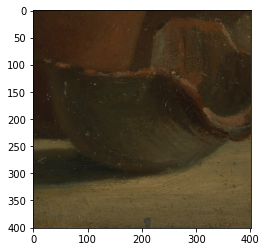

In [28]:
plt.imshow(wavelength2rgb(visible))
plt.imsave('image.png', wavelength2rgb(visible))

In [29]:
#Data
training_set_size = 25000
image_path = '../data/raw/still_life/sample_22.mat'
input_data = sio.loadmat(image_path)['data']
visible = input_data[:, :, 0:16] / 255.0
target = np.expand_dims(
    input_data[:, :,  26] / 255.0,
    axis=-1)

inputs = visible.reshape([visible.shape[0] * visible.shape[1],
                          1,
                          1,
                          visible.shape[2]])
outputs = target.reshape([target.shape[0] * target.shape[1],
                          1,
                          1,
                          target.shape[2]])
perm = np.random.permutation(inputs.shape[0])
ins  = inputs[perm[:training_set_size], :]
outs = outputs[perm[:training_set_size], :]

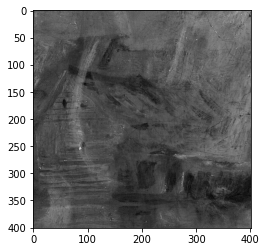

In [30]:
plt.imshow(target, cmap=plt.cm.gray)

In [31]:
input_shape = [1, 1, 16]
input_layer = keras.layers.Input(shape=input_shape)
num_layers = 2
filters = 15

layer = input_layer
for i in range(num_layers):
    layer = keras.layers.Conv2D(filters=25,
                                kernel_size=1,
                                activation='sigmoid',
                                padding='same')(layer)
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(layer)
model = keras.Model(inputs=input_layer, outputs=output_layer)

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 16)]        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 25)          425       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 25)          650       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 1)           26        
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error']
              )

callbacks = [tf.keras.callbacks.EarlyStopping(patience=6,
                                              min_delta=10 ** -5)]
history = model.fit(ins,
                    outs,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks
                    )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 79us/sample - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0041 - val_mean_squared_error: 0.0041

In [34]:
print(model.predict(inputs).shape)
print(outputs.shape)
# calculate gain and print it out
gain = abs(outputs - model.predict(inputs)) / (outputs.shape[0] * outputs.shape[1])
print('Gain: {:1.4e}'.format(gain.flatten().max()))

(160801, 1, 1, 1)
(160801, 1, 1, 1)
Gain: 3.0342e-06


In [42]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(target.shape)

diff = (target-approx) - np.min(target-approx)
diff = diff/np.max(diff)

imgs = np.concatenate([target, approx, diff], axis=1)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()


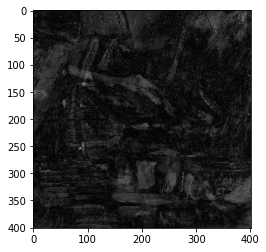

In [40]:
plt.imshow(diff, cmap=plt.cm.gray)

-0.2866829209467944

In [18]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(target.shape)

diff = np.abs(approx - target)
gamma_diff = np.expand_dims(
    adjust_gamma(
        (diff*255.0).astype(np.uint8),
        1.5
    )/255.0,
    axis=-1 )

imgs = np.concatenate([target, approx, gamma_diff], axis=1)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()
